In [1]:
import pandas as pd
import argparse
from pathlib import Path
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import accuracy, top_k_accuracy
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
from util import load_file_list

# data preparation

In [24]:
img_dir = Path('/media/F/projects/datasets/DeepFashion/Category-and-Attribute-Prediction-Benchmark/')
data_df = load_file_list(img_dir)
#print(data_df['dataset'].head(10))
#data_df = data_df[:10000]

data_source = (ImageList.from_df(df=data_df, path=img_dir, cols='images')
               .split_by_idxs((data_df[data_df['dataset'] == 'train'].index), (data_df[data_df['dataset'] == 'val'].index))
               .label_from_df(cols='category'))

tmfs = get_transforms()

data = data_source.transform(tmfs, size=224).databunch(bs=32, num_workers=4).normalize(imagenet_stats)

test_data = ImageList.from_df(df=data_df[data_df['dataset'] == 'test'], path=img_dir, cols='images')
data.add_test(test_data)

# load learner

In [25]:
learner = cnn_learner(data, models.resnet18, metrics=[accuracy])

# find learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


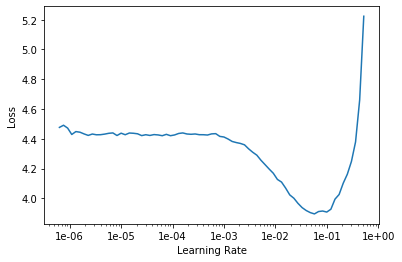

In [26]:
learner.lr_find()
learner.recorder.plot()

In [27]:
lr = 1e-2/2
n_epoch = 5
learner.fit_one_cycle(n_epoch, slice(lr))
learner.save('stage-1-rn50')
learner.export()

epoch,train_loss,valid_loss,accuracy,time
0,1.654975,1.493546,0.560225,12:18
1,1.602733,1.407550,0.586600,11:52
2,1.516214,1.356984,0.601050,12:21
3,1.449831,1.316180,0.613075,11:27
4,1.460459,1.304610,0.615600,11:12


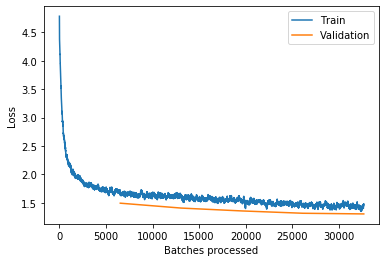

In [29]:
learner.recorder.plot_losses()

In [33]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


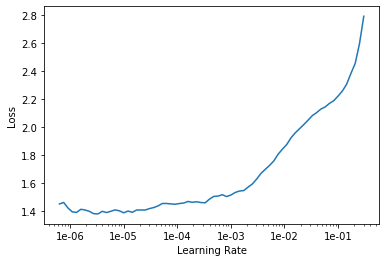

In [34]:
learner.lr_find()
learner.recorder.plot()

In [35]:
lr = 1e-5/2
learner.fit_one_cycle(5, slice(lr, lr/5))
learner.save('stage-2-rn50')

epoch,train_loss,valid_loss,accuracy,time
0,1.436234,1.291790,0.619500,11:44
1,1.362844,1.260713,0.630000,11:12
2,1.396668,1.238235,0.636775,11:10
3,1.399943,1.229970,0.639725,11:08
4,1.333646,1.227283,0.640325,11:08


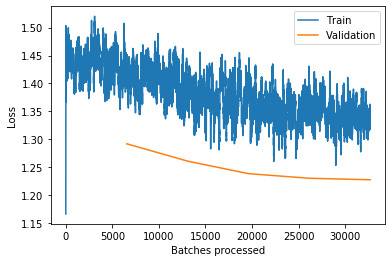

In [36]:
learner.recorder.plot_losses()

In [40]:
data = (data_source.transform(tmfs, size=256)
        .databunch().normalize(imagenet_stats))

learner.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [42]:
learner.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


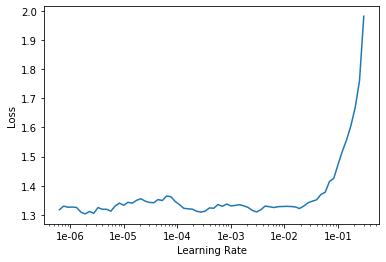

In [44]:
learner.lr_find()
learner.recorder.plot()

In [46]:
lr=1e-4
learner.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.305804,1.220491,0.643625,08:24
1,1.354606,1.214292,0.645325,08:30
2,1.310465,1.208748,0.646975,08:33
3,1.317268,1.209686,0.646275,08:38
4,1.342122,1.211086,0.645150,08:36


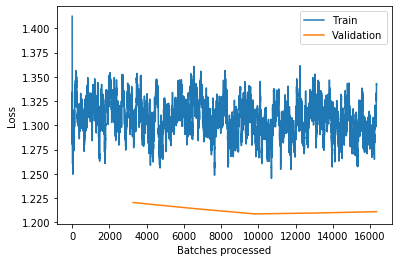

In [47]:
learner.recorder.plot_losses()

In [68]:
learner.save('stage-3-rn50')

In [69]:
learner.export()

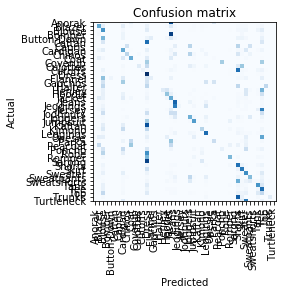

In [62]:
interp = ClassificationInterpretation.from_learner(learner)
fig = interp.plot_confusion_matrix(normalize=True, plot_txt=False)

In [64]:
data_source = (ImageList.from_df(df=data_df, path=img_dir, cols='images')
               .split_none()
               .label_from_df(cols='category'))

In [65]:
db = data_source.transform(get_transforms(), size=224).databunch()

In [70]:
learn_cln = cnn_learner(db, models.resnet18, metrics=error_rate)
learn_cln.load('stage-3-rn50');

In [72]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path)